<a href="https://colab.research.google.com/github/jvataidee/pdi_python/blob/main/classificacao_supervisionada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Classificação Supervisionada

### Instalar e Importar Bibliotecas

In [ ]:
!pip install spectral
!pip install rasterio

In [3]:
# Bibliotecas de GIS
from osgeo import gdal
from osgeo import ogr

In [4]:
# Outras bibliotecas
import pandas as pd
from spectral import *
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rio
from rasterio.plot import reshape_as_raster
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Rasterização  

In [5]:
# Leitura somente da banda 1
raster = gdal.Open('/content/drive/MyDrive/pdi_python/21 - PDI com Python/01 - Pré-Processamento/imagens/L71221071_07120010720_DN_B1.tif')

#Leitura da área de interesse
vetor = ogr.Open('/content/drive/MyDrive/pdi_python/21 - PDI com Python/03 - Classificações Temáticas/ROI.shp')

In [6]:
# Get layer
layer = vetor.GetLayer()

In [7]:
# Armazenando parâmetros cartográficos
transform = raster.GetGeoTransform()
transform

(160665.0, 30.0, 0.0, 8279275.0, 0.0, -30.0)

In [8]:
# Criando o raster
driver = gdal.GetDriverByName('GTiff')
raster_roi = driver.Create('roi.tif',raster .RasterXSize, raster .RasterYSize, 1, gdal.GDT_Int16)
raster_roi.SetGeoTransform(transform)

0

In [9]:
# Colocando informação do raster com o vetor
gdal.RasterizeLayer(raster_roi, [1], layer, options=['ATTRIBUTE=id'])
raster_roi.GetRasterBand(1).SetNoDataValue(0.0)
raster_roi = None

## Treinando modelo Nearest Neighbors

In [10]:
# Lendo imagem como array
src = rio.open('/content/drive/MyDrive/pdi_python/21 - PDI com Python/01 - Pré-Processamento/L71221071_07120010720_DN.tif')
b1 = src.read(1)
b2 = src.read(2)
b3 = src.read(3)
b4 = src.read(4)
b5 = src.read(5)
b7 = src.read(6)

img = np.dstack([b1,b2,b3,b4,b5,b7])

In [11]:
# Armazenando metadados
meta = src.profile

In [12]:
# Lendo classes
with rio.open('/content/roi.tif') as src2:
  gt = src2.read(1)

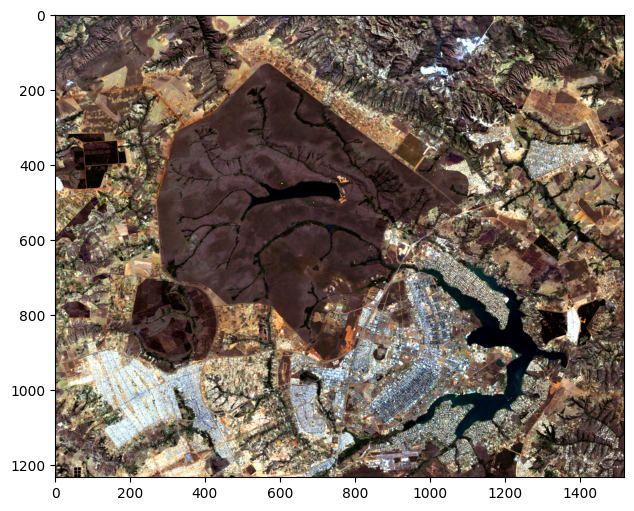

In [16]:
view = imshow(img, (2,1,0), classes=gt, stretch=(0.02,0.98), figsize=(8,6))
view.set_display_mode('overlay');

In [18]:
# Criar classes de treinamento para o classificador Gaussiano usando a imagem e os dados de referência
classes_gaussian = create_training_classes(img, gt)

# Criar uma instância do classificador Gaussiano com as classes de treinamento e um tamanho mínimo de amostra de 20
gmlc = GaussianClassifier(classes_gaussian, min_samples=20)

# Classificar a imagem usando o classificador Gaussiano
clmap = gmlc.classify_image(img)

Processing...  0.0%Processing... 16.7%Processing... 33.3%Processing... 50.0%Processing... 66.7%Processing... 83.3%Processing... 100.0%Processing...done   


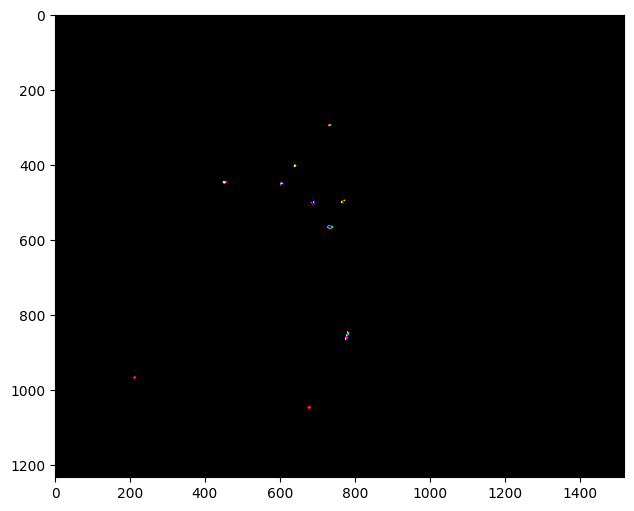

In [22]:
# Visualizando erro no treinamento
clmap_error = clmap * (gt != 0)
imshow(classes=clmap_error, figsize=(8,6));

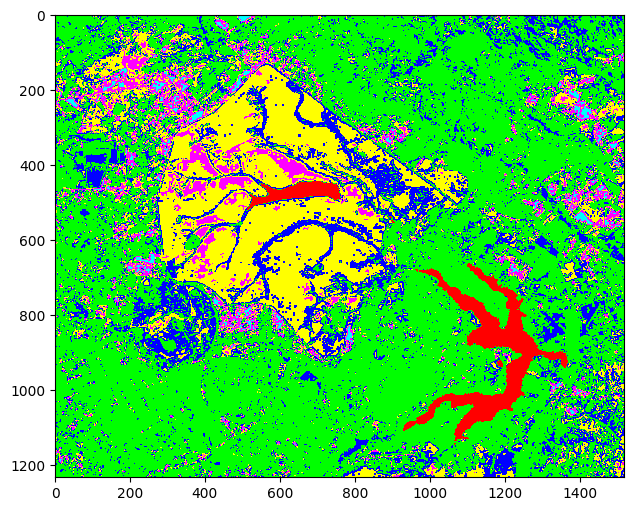

In [21]:
# Visualizando classificação
imshow(classes=clmap, figsize=(8,6));

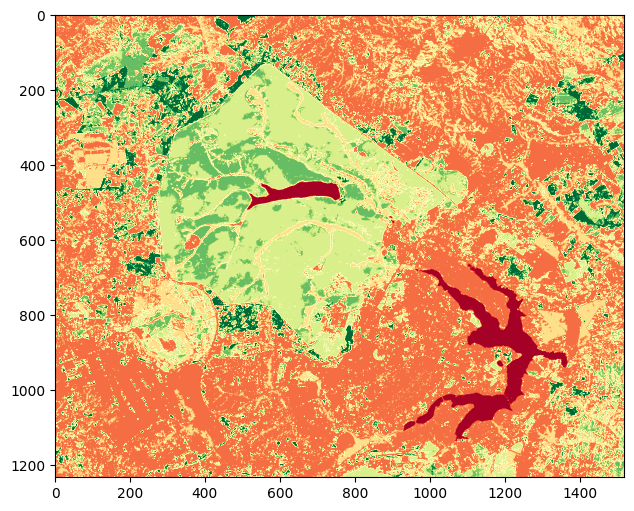

In [23]:
plt.figure(figsize=(8,6))
plt.imshow(clmap, cmap='RdYlGn')
plt.show()

In [24]:
# Gravando metada dado
meta.update({'count': 1})

In [25]:
# Salvar resultado
with rio.open('glmc.tif', 'w', **meta) as src:
  src.write(clmap,1)

## Treinando modelo  Multi-Layer Perceptron
[Multi-Layer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)

In [26]:
# Criando modelo
classes_mlp = create_training_classes(img,gt)

inputs = img.shape[2]
outputs = len(classes_mlp)

In [ ]:
# Criar uma instância do classificador perceptron com as classes de treinamento e um tamanho mínimo de amostra de 20
p = PerceptronClassifier([inputs, 20,10, outputs])

# Treinar modelo
p.train(classes_mlp, 20, clip=0., accuracy=100, batch=5, momentum=0.3, rate=0.5)

# Classificar a imagem usando o classificador Gaussiano
c = p.classify(img)

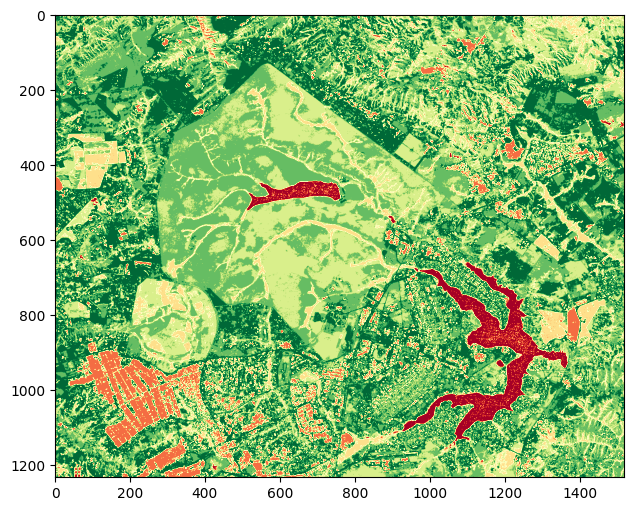

In [29]:
plt.figure(figsize=(8,6))
plt.imshow(c, cmap='RdYlGn')

In [30]:
# Salvar resultado
with rio.open('mlp.tif', 'w', **meta) as src:
  src.write(c,1)

## Treinando modelo  Análise Discriminante Linear de Fisher

In [32]:
# Criar uma instância do classificador fisher
classes_fld = create_training_classes(img,gt)

# criando modelo
fld = linear_discriminant(classes_fld)

# Treinar modelo
fld_img = fld.transform(img)

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


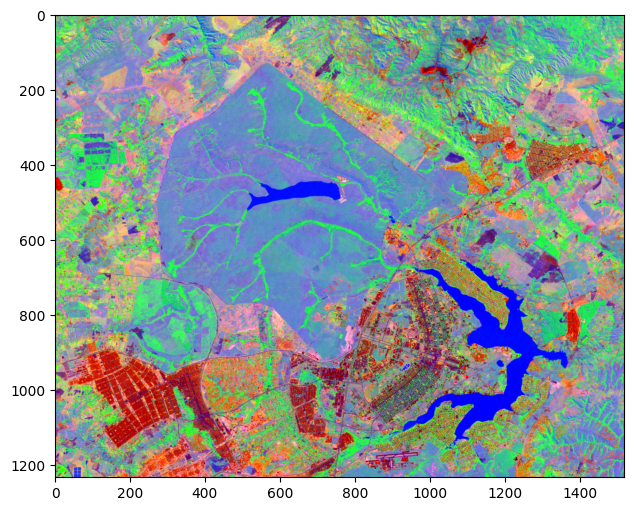

In [33]:
imshow(fld_img, (0,1,2), stretch=(0.02,0.98), figsize=(8,6));

In [35]:
# Criando modelo MLP
# Criando as classes de treinamento com a imagem fld_img e os rótulos gt
classes_mlp_fld = create_training_classes(fld_img, gt)

# Obtendo o número de características de entrada
inputs_fld = fld_img.shape[2]

# Obtendo o número de classes de saída
outputs_fld = len(classes_mlp_fld)

# Criando um objeto PerceptronClassifier com a estrutura da MLP
p_fld = PerceptronClassifier([inputs_fld, 20, 10, outputs_fld])

# Treinando a MLP com as classes de treinamento
p_fld.train(classes_mlp_fld, 20, clip=0., accuracy=100, batch=1, momentum=0.3, rate=0.5)

# Classificando a imagem fld_img com o modelo MLP treinado
c_fld = p_fld.classify(fld_img)

Iter     0: Accuracy = 55.00% E = 34.441030
Iter     1: Accuracy = 30.00% E = 42.723071
Iter     2: Accuracy = 22.50% E = 44.543196
Iter     3: Accuracy = 15.83% E = 45.770709
Iter     4: Accuracy = 10.83% E = 46.468562
Iter     5: Accuracy = 7.50% E = 46.732943
Iter     6: Accuracy = 5.83% E = 46.575746
Iter     7: Accuracy = 9.17% E = 45.884567
Iter     8: Accuracy = 14.17% E = 44.340879
Iter     9: Accuracy = 20.83% E = 41.699170
Iter    10: Accuracy = 29.17% E = 38.505695
Iter    11: Accuracy = 34.17% E = 35.730312
Iter    12: Accuracy = 38.33% E = 33.607340
Iter    13: Accuracy = 43.33% E = 31.645811
Iter    14: Accuracy = 45.83% E = 29.590098
Iter    15: Accuracy = 50.00% E = 27.529325
Iter    16: Accuracy = 55.83% E = 25.597262
Iter    17: Accuracy = 58.33% E = 23.906663
Iter    18: Accuracy = 62.50% E = 22.485539
Iter    19: Accuracy = 65.00% E = 21.227259
Iter    20: Accuracy = 66.67% E = 19.973406
Iter    21: Accuracy = 69.17% E = 18.669699
Iter    22: Accuracy = 71.67% E = 1

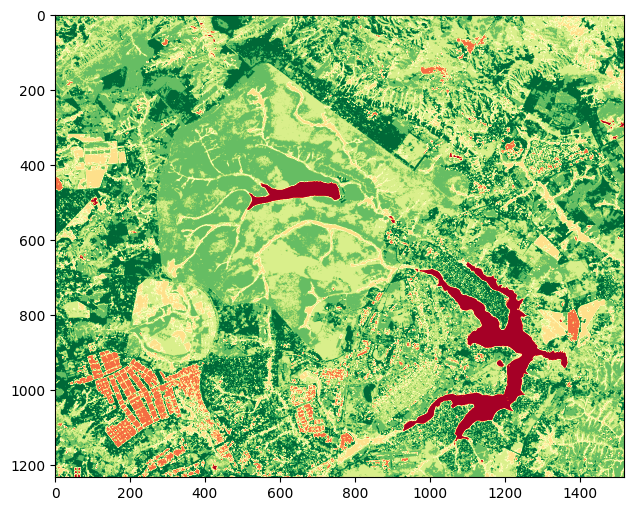

In [37]:
plt.figure(figsize=(8,6))
plt.imshow(c_fld, cmap='RdYlGn');

In [38]:
# Salvar resultado MLP FLD
with rio.open('mlp_fld.tif', 'w', **meta) as src:
  src.write(c_fld,1)

In [39]:
meta.update({'count':5})

In [40]:
fld_img_r = reshape_as_raster(fld_img)

In [41]:
# Salvar resultado FLD
with rio.open('fld.tif', 'w', **meta) as src:
  src.write(fld_img_r)

## Treinando modelo  KNN

In [42]:
# Lendo classes
with rio.open('/content/roi.tif') as src2:
  roi = src2.read(1)

In [43]:
# Criando conjunto de treino
X = img[roi > 0]
y  = roi[roi > 0]

In [69]:
# Dividindo conjunto em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size = 0.95)

In [70]:
# Instanciando o classificador
knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [71]:
# Criando matriz com bandas em colunas
img2d = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

# Rodando predição
pred_knn = knn.predict(img2d)

# Retornando para o formato original
pred_knn_final = pred_knn.reshape(img[:,:,0].shape)

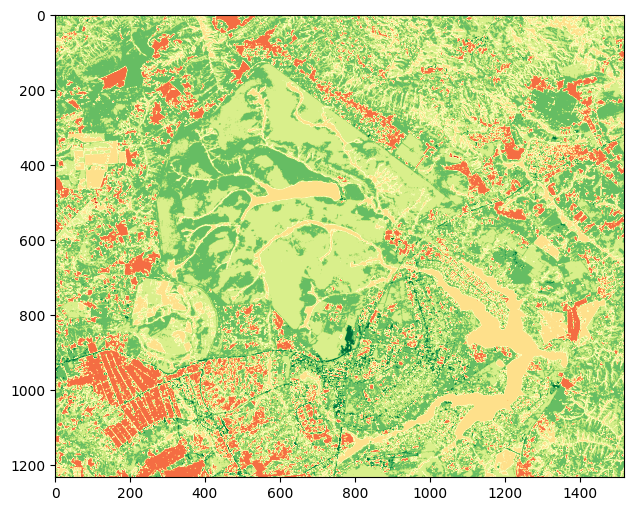

In [72]:
plt.figure(figsize=(8,6))
plt.imshow(pred_knn_final, cmap='RdYlGn');

In [73]:
# Classification report
pred = knn.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        90
           2       0.74      0.97      0.84       111
           3       0.63      1.00      0.77       152
           4       1.00      1.00      1.00       135
           5       0.97      1.00      0.99        99
           6       0.99      0.74      0.85       145

    accuracy                           0.82       732
   macro avg       0.72      0.79      0.74       732
weighted avg       0.76      0.82      0.77       732



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
accuracy_score(y_test, pred)

0.8210382513661202

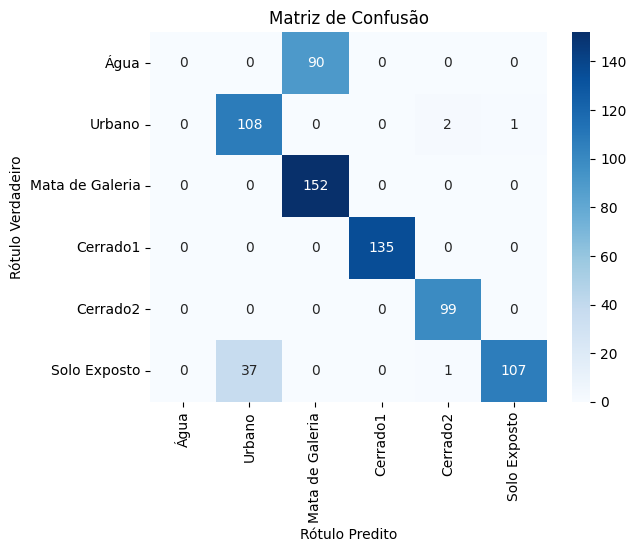

In [75]:
# Definindo as classes
classes = ['Água', 'Urbano', 'Mata de Galeria', 'Cerrado1', 'Cerrado2', 'Solo Exposto']

cm = confusion_matrix(y_test, pred)

# Criando uma visualização da matriz de confusão
plt.figure()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

## Treinando modelo  Random Forest

In [76]:
# Instanciando modelo random forest
rf = RandomForestClassifier(n_estimators= 500, max_depth=1000, n_jobs=-1, oob_score=True)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=1000, n_estimators=500, n_jobs=-1,
                       oob_score=True)

In [77]:
print("Score", rf.oob_score_ * 100)

Score 100.0


In [78]:
rf.feature_importances_

array([0.16111921, 0.19716654, 0.18534621, 0.11062255, 0.13853648,
       0.20720901])

In [79]:
# Rodando predição
pred_rf = rf.predict(img2d)

# Retornando para o formato original
pred_rf_final = pred_rf.reshape(img[:,:,0].shape)

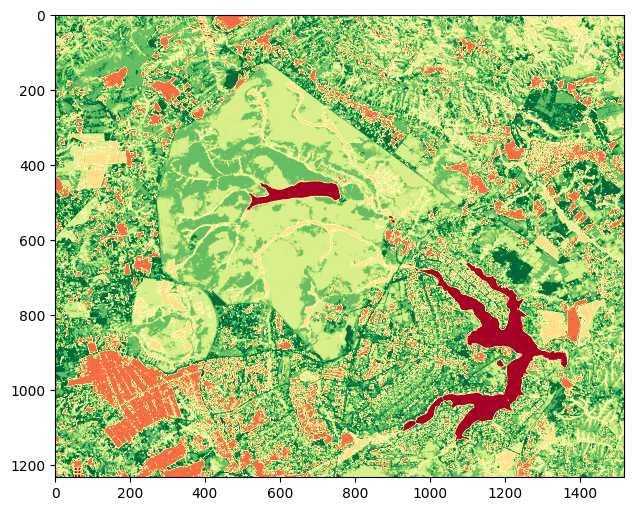

In [80]:
# Visualizando
plt.figure(figsize=(8,6))
plt.imshow(pred_rf_final, cmap='RdYlGn');

In [81]:
pred = rf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        90
           2       0.97      0.99      0.98       111
           3       1.00      1.00      1.00       152
           4       1.00      1.00      1.00       135
           5       1.00      1.00      1.00        99
           6       0.99      0.98      0.99       145

    accuracy                           0.99       732
   macro avg       0.99      1.00      0.99       732
weighted avg       0.99      0.99      0.99       732



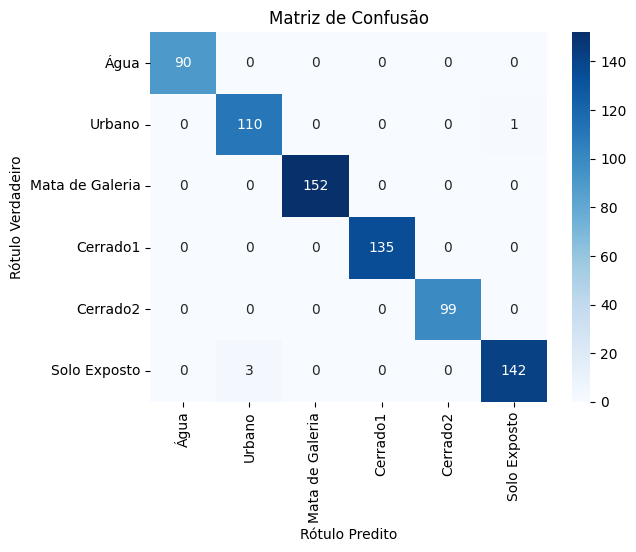

In [82]:
# Definindo as classes
classes = ['Água', 'Urbano', 'Mata de Galeria', 'Cerrado1', 'Cerrado2', 'Solo Exposto']

cm = confusion_matrix(y_test, pred)

# Criando uma visualização da matriz de confusão
plt.figure()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

In [83]:
# Tunning de Hiperparâmetros
depth = [1,5,10,15,25,50,100,200,30,400,500]
accu = []

for i in depth:
  rf2 = RandomForestClassifier(n_estimators= i, max_depth=1000, n_jobs=-1)
  rf2.fit(X_train, y_train)
  pred3 = rf2.predict(X_test)
  accu.append(accuracy_score(y_test, pred3))
  print('Acurácia para árvores = {} é: {}'.format(i, accuracy_score(y_test, pred3)))

Acurácia para árvores = 1 é: 0.8401639344262295
Acurácia para árvores = 5 é: 0.9275956284153005
Acurácia para árvores = 10 é: 0.994535519125683
Acurácia para árvores = 15 é: 0.9931693989071039
Acurácia para árvores = 25 é: 0.994535519125683
Acurácia para árvores = 50 é: 0.9931693989071039
Acurácia para árvores = 100 é: 0.994535519125683
Acurácia para árvores = 200 é: 0.994535519125683
Acurácia para árvores = 30 é: 0.994535519125683
Acurácia para árvores = 400 é: 0.994535519125683
Acurácia para árvores = 500 é: 0.994535519125683


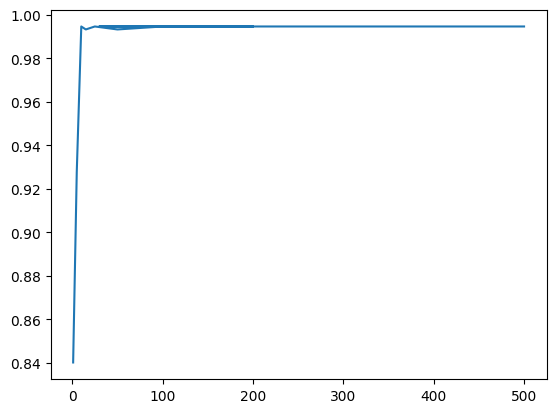

In [84]:
plt.plot(depth, accu)
plt.show()

## Treinando modelo  SVM

In [85]:
# Instanciando modelo Suporte Vector Machine
svm = SVC()

svm.fit(X_train, y_train)

SVC()

In [86]:
# Rodando predição
pred_svm = svm.predict(img2d)

# Retornando para o formato original
pred_svm_final = pred_svm.reshape(img[:,:,0].shape)

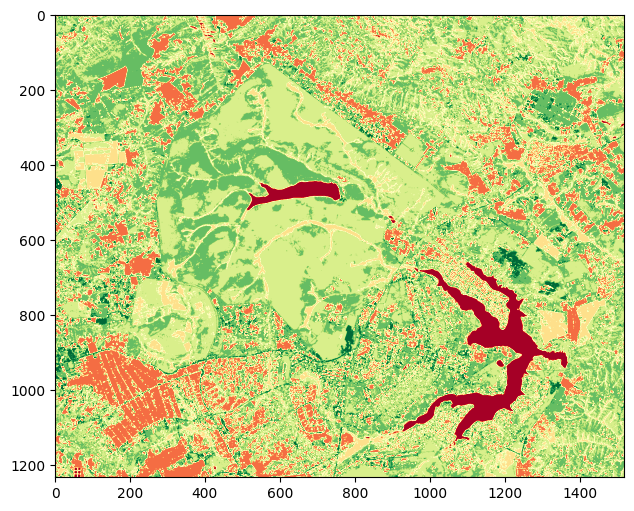

In [87]:
# Visualizando
plt.figure(figsize=(8,6))
plt.imshow(pred_svm_final, cmap='RdYlGn');

In [88]:
pred = svm.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        90
           2       0.87      1.00      0.93       111
           3       1.00      1.00      1.00       152
           4       1.00      1.00      1.00       135
           5       1.00      1.00      1.00        99
           6       1.00      0.88      0.94       145

    accuracy                           0.98       732
   macro avg       0.98      0.98      0.98       732
weighted avg       0.98      0.98      0.98       732



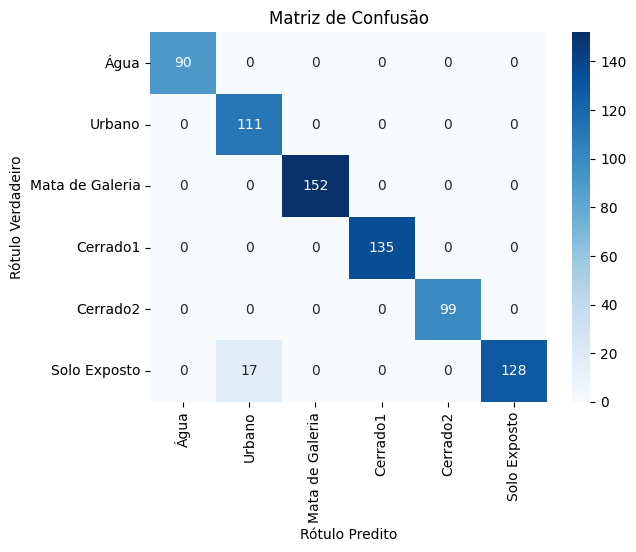

In [89]:
# Definindo as classes
classes = ['Água', 'Urbano', 'Mata de Galeria', 'Cerrado1', 'Cerrado2', 'Solo Exposto']

cm = confusion_matrix(y_test, pred)

# Criando uma visualização da matriz de confusão
plt.figure()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()